In [170]:
# Set seeds for repeatability.
from numpy.random import seed
seed(1)

from context import omphalos

# Import data processing modules.
import pandas as pd
import numpy as np

import gpflow

import tensorflow as tf
import tensorflow_probability as tfp

from gpflow.ci_utils import ci_niter
from gpflow import set_trainable

from gpflow.utilities import print_summary, set_trainable, to_default_float

# convert to float64 for tfp to play nicely with gpflow in 64
f64 = gpflow.utilities.to_default_float

# Import Omphalos modules.
from omphalos import generate_inputs as gi
from omphalos import file_methods as fm
from omphalos import my_metrics as mm
from omphalos import omphalos_plotter as op
from omphalos import attributes as attr
from omphalos import labels as lbls

# Import data visualisation modules.
import seaborn as sns
import matplotlib.pyplot as plt

# Import sklearn. 
import sklearn.preprocessing as skp
import sklearn.gaussian_process as gp
import sklearn.gaussian_process.kernels as kernels

In [2]:
train_set = fm.unpickle('data/rifle_train.pickle')

attributes_df = attr.boundary_condition(train_set, boundary='x_begin')
labels_df = lbls.secondary_precip(train_set)

/usr/local/lib/python3.8/site-packages/pandas/core/frame.py:6390: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


# SK-learn pipeline

In [3]:
x = attributes_df.loc[:, ['NH4+', 'SO4--','Ca++', 'Acetate', 'CO2(aq)']]
y = labels_df.xs(1, level=1)['CalciteRifle']

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.8)

In [4]:
print(np.shape(x_train.to_numpy()))
print(np.shape(y_train.to_numpy().reshape(-1,1)))

(1996, 5)
(1996, 1)


In [5]:
x_train = x_train.to_numpy() 
y_train = y_train.to_numpy().reshape(-1,1)

In [166]:
k = gpflow.kernels.Matern32(variance=0.0005, lengthscales=[10, 30, 10], active_dims=[1,2,4])

k.variance.prior = tfp.distributions.Gamma(concentration=f64([1,1,1]), rate=f64([0.0002, 0.0002, 0.0002]))
k.lengthscales.prior = tfp.distributions.Gamma(concentration=f64([1,1,1]), rate=f64([0.11, 0.185, 31]))
print_summary(k)


m = gpflow.models.GPR(data=(x_train, y_train), kernel=k, mean_function=None)
m.likelihood.variance.prior = tfp.distributions.Gamma(concentration=f64([1,1,1]), rate=f64([0.0002, 0.0002, 0.0002]))

print_summary(m)

opt = gpflow.optimizers.Scipy()

╒═══════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════════╕
│ name                  │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │ value                 │
╞═══════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════════╡
│ Matern32.variance     │ Parameter │ Softplus    │ Gamma   │ True        │ ()      │ float64 │ 0.0004999999999999997 │
├───────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────────┤
│ Matern32.lengthscales │ Parameter │ Softplus    │ Gamma   │ True        │ (3,)    │ float64 │ [10. 30. 10.]         │
╘═══════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧═══════════════════════╛
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════════╕
│ name                    │ class

In [167]:
opt_logs = opt.minimize(m.training_loss, m.trainable_variables, options=dict(maxiter=500))
print_summary(m)

print(f"log posterior density at optimum: {m.log_posterior_density()}")

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════════════════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                                    │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════════════════════════════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │ 1.0985776611345657e-05                   │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────────────────────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │ Gamma   │ True        │ (3,)    │ float64 │ [177.42821698  35.80027989   2.29818604] │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────────

In [ ]:
num_burnin_steps = ci_niter(300)
num_samples = ci_niter(500)

# Note that here we need model.trainable_parameters, not trainable_variables - only parameters can have priors!
hmc_helper = gpflow.optimizers.SamplingHelper(
    m.log_posterior_density, m.trainable_parameters
)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=hmc_helper.target_log_prob_fn, num_leapfrog_steps=10, step_size=0.01
)
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    hmc, num_adaptation_steps=10, target_accept_prob=f64(0.75), adaptation_rate=0.1
)


@tf.function
def run_chain_fn():
    return tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=num_burnin_steps,
        current_state=hmc_helper.current_state,
        kernel=adaptive_hmc,
        trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,
    )


samples, traces = run_chain_fn()
parameter_samples = hmc_helper.convert_to_constrained_values(samples)

param_to_name = {param: name for name, param in gpflow.utilities.parameter_dict(m).items()}

In [ ]:
def plot_samples(samples, parameters, y_axis_label):
    plt.figure(figsize=(8, 4))
    for val, param in zip(samples, parameters):
        plt.plot(tf.squeeze(val), label=param_to_name[param])
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.xlabel("HMC iteration")
    plt.ylabel(y_axis_label)


plot_samples(samples, m.trainable_parameters, "unconstrained values")
plot_samples(parameter_samples, m.trainable_parameters, "constrained parameter values")

In [ ]:
def marginal_samples(samples, parameters, y_axis_label):
    fig, axes = plt.subplots(1, len(param_to_name), figsize=(15, 3), constrained_layout=True)
    for ax, val, param in zip(axes, samples, parameters):
        ax.hist(np.stack(val).flatten(), bins=20)
        ax.set_title(param_to_name[param])
    fig.suptitle(y_axis_label)
    plt.show()


marginal_samples(samples, m.trainable_parameters, "unconstrained variable samples")
marginal_samples(parameter_samples, m.trainable_parameters, "constrained parameter samples")

In [ ]:
def plot_joint_marginals(samples, parameters, y_axis_label):
    name_to_index = {param_to_name[param]: i for i, param in enumerate(parameters)}
    f, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

    axs[0].plot(
        samples[name_to_index[".likelihood.variance"]],
        samples[name_to_index[".kernel.variance"]],
        "k.",
        alpha=0.15,
    )
    axs[0].set_xlabel("noise_variance")
    axs[0].set_ylabel("signal_variance")

    axs[1].plot(
        samples[name_to_index[".likelihood.variance"]],
        samples[name_to_index[".kernel.lengthscales"]],
        "k.",
        alpha=0.15,
    )
    axs[1].set_xlabel("noise_variance")
    axs[1].set_ylabel("lengthscale")

    axs[2].plot(
        samples[name_to_index[".kernel.lengthscales"]],
        samples[name_to_index[".kernel.variance"]],
        "k.",
        alpha=0.1,
    )
    axs[2].set_xlabel("lengthscale")
    axs[2].set_ylabel("signal_variance")
    f.suptitle(y_axis_label)
    plt.show()


plot_joint_marginals(samples, m.trainable_parameters, "unconstrained variable samples")
plot_joint_marginals(parameter_samples, m.trainable_parameters, "parameter samples")

In [ ]:
# plot the function posterior
xx = np.linspace(-0.1, 1.1, 100)[:, None]
plt.figure(figsize=(12, 6))

for i in range(0, num_samples, 20):
    for var, var_samples in zip(hmc_helper.current_state, samples):
        var.assign(var_samples[i])
    f = m.predict_f_samples(xx, 1)
    plt.plot(xx, f[0, :, :], "C0", lw=2, alpha=0.3)

plt.plot(X, Y, "kx", mew=2)
_ = plt.xlim(xx.min(), xx.max())
_ = plt.ylim(0, 6)
plt.xlabel("$x$")
plt.ylabel("$f|X,Y$")
plt.title("Posterior GP samples")

plt.show()

# Plot cross-section of model.

(50, 5)
(50, 1)


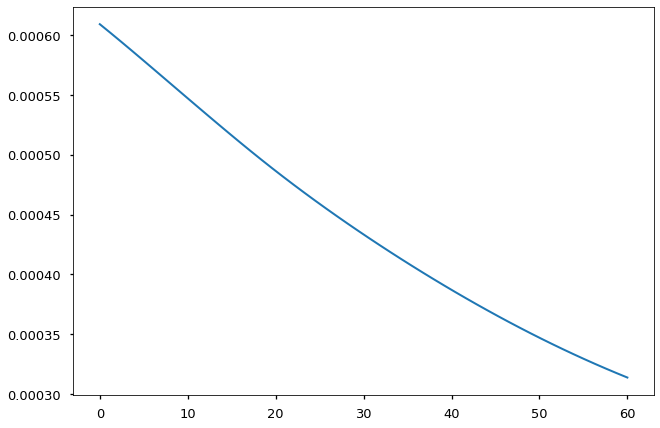

In [168]:
samples = 50
x_pred = np.ones((samples, 5))
x_pred[:,0] = 1.5
x_pred[:,2] = 5
x_pred[:,4] = 0.0325
#x_pred[:,1] = x.to_numpy()[:,1].mean()
x_pred[:,1] =  np.linspace(0.0, 60.0, samples)
x_pred[:,3] = 9.7
print(np.shape(x_pred))
mean, var = m.predict_f(x_pred)
print(np.shape(mean))


tf.random.set_seed(1)  # for reproducibility
samples = m.predict_f_samples(x_pred, 10)  

plt.style.use('seaborn-talk')
plt.plot(x_pred[:,1], mean, "C0", lw=2)